In [3]:
# do required imports
import difflib
import torch
from torch.autograd import Variable
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2834)
import matplotlib.ticker as mtick
import matplotlib as matplotlib
matplotlib.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import Counter

In [4]:
lm = torch.load('model.pt', map_location=lambda storage, loc: storage)

In [5]:
# calculate word frequencies
train_data = []
with open('train.txt', 'r', encoding='utf-8') as infile:
    for line in infile:
        for word in line.split():
            train_data.append(word)
counter = Counter(train_data)

In [6]:
# Load dictionary word --> id 
dictionary = pickle.load(open('dict', 'rb'))

# set the maximum sequence length
max_seq_len = 50

# function to transform sentence into word id's and put them in a pytorch Variable
# NB Assumes the sentence is already tokenised!
def tokenise(sentence, dictionary):
    words = sentence.split(' ')
    l = len(words)
    assert l <= max_seq_len, "sentence too long"
    token = 0
    ids = torch.LongTensor(l)

    for word in words:
        try:
            ids[token] = dictionary.word2idx[word]
        except KeyError:
            print( word)
            raw_input()
            ids[token] = dictionary.word2idx['<unk>']
        token += 1
    return ids

In [7]:
# load pytorch softmax function
softmax = nn.Softmax()

def evaluate(model, dictionary, sentence, check_words):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    # number of tokens (= output size)
    ntokens = len(dictionary)
    hidden = model.init_hidden(1)
    
    # tokenise the sentence, put in torch Variable
    test_data = tokenise(sentence, dictionary)
    input_data = Variable(test_data, volatile=True)

    # run the model, compute probabilities by applying softmax
    output, hidden = model(input_data, hidden)
    output_flat = output.view(-1, ntokens)
    logits = output[-1, :]
    sm = softmax(logits).view(ntokens)
    
    # get probabilities of certain words by looking up their
    # indices and print them
    def get_prob(word):
        return sm[dictionary.word2idx[word]].data[0]

    #print (sentence, '\n')
    #print ('\n'.join(
    #        ['%s: %f' % (word, get_prob(word)) for word in check_words]
    #        ) )
    return  [{word : get_prob(word)} for word in check_words]

In [8]:
# Compose sentence prefixes with frequent words.
# The sentence prefixes are intended to test intervening nouns.


NN = ['company', 'year', 'market', 'share', 'stock', 'system', 'president', 'business', 
      'quarter', 'government', 'time', 'week', 'price', 'group', 'interest',
      'industry', 'unit','month', 'rate', 'investment', 'state', 'producer', 'income', 
      'program', 'bank', 'part', 'plan', 'sale', 'issue', 'tax', 'way', 'loss', 'executive', 'day', 'bid', 'data', 'line','hour', 'plant', 'concern']

NNS = ['companies', 'years', 'markets', 'shares', 'stocks', 'systems', 'presidents', 
       'businesses', 'quarters', 'governments', 'times', 'weeks', 'prices', 'groups', 'interests', 'industries', 
       'units', 'months', 'rates', 'investments', 'states', 'producers', 'incomes', 'programs', 'banks', 'parts', 'plans', 
      'sales', 'issues', 'taxes', 'ways', 'losses', 'executives', 'days', 'bids', 'data', 'lines', 'hours', 'plants', 'concerns',]

VBP = ['are', 'have', 'do', 'say', 'think', 'want', 'expect', 'include', 'ask', 
       'make', 'need', 'know', 'see', 'get', 'seem', 'remain', 'continue', 'show', 'buy', 
       'feel', 'go', 'sell', 'take', 'use', 'plan', 'look', 'tend', 'hope', 'argue', 'give',
       'pay', 'appear', 'suggest', 'fear', 'find', 'come', 'offer', 'contend', 'agree', 'provide']

VBZ = ['is', 'has', 'does', 'says', 'thinks', 'wants', 'expects', 'includes', 'asks', 'makes',
      'needs', 'knows', 'sees', 'gets', 'seems', 'remains', 'continues', 'shows', 'buys', 'feels', 'goes', 'sells',
      'takes', 'uses', 'plans', 'looks', 'tends', 'hopes', 'argues', 'gives', 'pays', 'appears', 'suggests', 'fears',
      'finds', 'comes', 'offers', 'contends', 'agrees', 'provides']

attractor_helpers = ['in the', 'by the', 'close to the', 'of the', 'at the', 'and not the', 'without']


In [9]:
def calculate_error_rate(sentences):
    result = calculate_errors(sentences)
    #print(result)
    return 1- sum(result)/len(result)
    
def calculate_errors(sentences):
    return [calculate_error(s) for s in sentences]

def calculate_error(sentence):
    return 1 if is_correct_prediction(sentence[0], sentence[1], sentence[2]) else 0 

def is_correct_prediction(sentence, check_words, correct_word):
    predictions = evaluate(lm, dictionary, sentence, check_words)
    words,preds = zip(*list(map(lambda x: list(x.items())[0],predictions)))
    predicted_word = words[np.argmax(preds)]
    return predicted_word == correct_word

def prob_ratio(sent):
    sentence, check_words, correct_word = sent[0], sent[1], sent[2]
    predictions = evaluate(lm, dictionary, sentence, check_words)
    words,preds = zip(*list(map(lambda x: list(x.items())[0],predictions)))
    #return log ratio
    #print(words)
    #return np.log(preds[0]/preds[1])
    return preds[0] / (preds[0] + preds[1])

In [10]:
# Compose sentence prefixes with frequent words with one and without attractors

def gen_simple_case_matrix(NN, NNS, VBP, VBZ):
    assert(len(VBP) == len(VBZ))
    nouns = NN + NNS
    noun_count = len(nouns)
    verb_count = len(VBP)
    result = []
    result_ratio = []
    for index_noun in range(noun_count):
        row = []
        row_ratio = []
        for index_verb in range(verb_count):
            correct = VBZ[index_verb] if index_noun < len(NN) else VBP[index_verb]
            sentence = (f"the {nouns[index_noun]}", [VBP[index_verb], VBZ[index_verb]], correct)
            #row.append(sentence)
            row.append(calculate_error(sentence))
            row_ratio.append(prob_ratio(sentence))
        result.append(row)
        result_ratio.append(row_ratio)
    return result,result_ratio

In [11]:
# simple cases: nouns x verbs results, 0 = error, 1 = correct
# first half of the rows are singular nouns,
# second half are plural nouns
n = 40

# matrix indicationg erros, matrix indicating error ratio
# NOUN x VERB, first half of the rows are singular nouns 
# 1 = correct 0 = error
noun_verb_matrix_errors,noun_verb_matrix_ratio = np.array(gen_simple_case_matrix(NN[0:n], NNS[0:n], VBP[0:n], VBZ[0:n]))

In [31]:
# Todo sort columns and rows and make sense of it (by looking at frequencies)

# matrix indicating 'singular' prediction (1=singular, 0 = plural)
noun_verb_matrix_singular_prediction = noun_verb_matrix_errors.copy()
f = np.vectorize(lambda x: 0 if x == 1 else 1)
noun_verb_matrix_singular_prediction[n:] = f(noun_verb_matrix_errors[n:])
noun_verb_matrix_singular_prediction # NOUN x VERB, 1 = singular prediction, 0 = plural prediction

# sort columns (verbs) by their preference for singular prediction
noun_verb_matrix_singular_prediction_sorted_idx_col = np.argsort(-noun_verb_matrix_singular_prediction.sum(axis=0))
noun_verb_matrix_singular_prediction_sorted_col = noun_verb_matrix_singular_prediction[:, noun_verb_matrix_singular_prediction_sorted_idx_col]

# split in NN and NNS
matrix_NN = noun_verb_matrix_singular_prediction_sorted_col[:n]
matrix_NNS = noun_verb_matrix_singular_prediction_sorted_col[n:]

# sort rows by their preference for singular prediction
matrix_NN_sorted_idx_row = np.argsort(-matrix_NN.sum(axis=1))
matrix_NN_sorted_row = matrix_NN[matrix_NN_sorted_idx_row,:]
matrix_NNS_sorted_idx_row = np.argsort(-matrix_NNS.sum(axis=1))
matrix_NNS_sorted_row = matrix_NNS[matrix_NNS_sorted_idx_row,:]

#concatenate matrices
matrix = np.concatenate((matrix_NN_sorted_row, matrix_NNS_sorted_row),axis=0)

# NOUN x VERB, first half of the rows are singular nouns (NN) second half are plural nouns (NNS)
# 1 = singular prediction, 0 = plural prediction
# columns are sorted as follows: 
#   verb with preference for singular (VBZ) ... verb with preference for plural (VBP)
# rows are sorted as follows: 
#   singular noun (NN) correctly predicted singular most of the time
#   ...
#   singular noun (NN) incorrectly predicted plural often
#   plural noun (NNS) incorrectly predicted singular often
#   ...
#   plural noun (NNS) correctly predicted plural most of the time



array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

(80, 40)


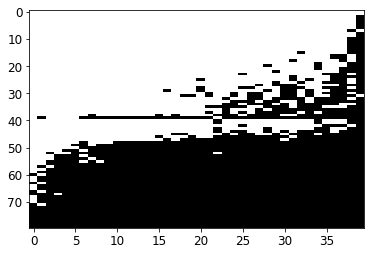

In [32]:
print(matrix.shape)
plt.imshow(matrix, cmap=cm.gray,aspect='auto')
plt.show()
plt.imsave('matrix_plot.png',matrix, cmap=cm.gray)

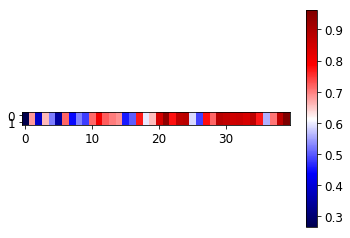

In [38]:
# IDEA: 
# Color code verb plurality ratios, i.e. Count(produce)/(Count(produces) + Count(produce)) 
# and print below diagram as some sort of 'x-axis'

vector_verbs = []
for i in range(n):
    vector_verbs.append(counter[VBP[i]] / (counter[VBP[i]] + counter[VBZ[i]]))
vector_verbs = np.array(vector_verbs)

# sort after singularity matrix column order
vector_verbs = vector_verbs[noun_verb_matrix_singular_prediction_sorted_idx_col]

plt.imshow([vector_verbs,vector_verbs], cmap=cm.seismic)
plt.colorbar()
plt.show()
plt.imsave('vector_verbs.png',[vector_verbs,vector_verbs], cmap=cm.seismic)

# We see that verbs with a low plurality rate (blue) tend to predict singlar (left)
# and that verbs with a high plurality rate (red) tend to predict plural (right)
# but this is not always the case

#TODO: better plot (?)
#   x-axis plurality rate, 
#   y-axis number of plural predictions (for plurals and for singulars) 

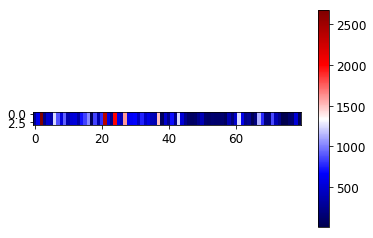

In [57]:
# Color code noun counts, i.e. Count(company)
# and print at the left of the diagram as some sort of 'y-axis'
# sort after index NN col
vector_nouns = []
for i in range(n):
    vector_nouns.append(counter[NN[i]])
for i in range(n):
    vector_nouns.append(counter[NNS[i]])
vector_nouns = np.array(vector_nouns)

# sort noun order
row_indices = np.append(matrix_NN_sorted_idx_row, matrix_NNS_sorted_idx_row + n)
vector_nouns = vector_nouns[row_indices]


# really divide by the max of NN and NNS?
# vector_nouns = vector_nouns/max(vector_nouns)
#vector_nouns[0:n] = vector_nouns[0:n]/max(vector_nouns[0:n])
#vector_nouns[n:2*n] = vector_nouns[n:2*n]/max(vector_nouns[n:2*n])
plt.imshow([vector_nouns,vector_nouns,vector_nouns,vector_nouns], cmap=cm.seismic)
plt.colorbar()
plt.show()
plt.imsave('vector_nouns.png',[vector_nouns,vector_nouns], cmap=cm.seismic)

# What we hoped to see is that the nouns in the middle (i.e. the nouns where a lot of errors were made) 
# had a low count. This is not clear from the picture though.
# What we do see is that plurals tend to have lower count than singulars,
# which may or may not explain the slightly higher error rate for plurals

In [68]:
i2w = np.vectorize(lambda i: NN[i] if i < n else NNS[i-n])
sorted_nouns = i2w(row_indices)
for i,w in enumerate(sorted_nouns):
    print(i,w, matrix[i,:].mean(), vector_nouns[i])

# 1 = all predictions singular, 0 = all predictions plural
# We see that the singular word 'income' seems to be miscounted as plural (0.15)
# We see a lot of plural words that seem to be miscounted (40 - 47)
# We do not see a clear relation with frequencies

0 plant 1.0 262
1 industry 1.0 602
2 company 0.975 2680
3 line 0.975 228
4 issue 0.975 489
5 system 0.975 360
6 president 0.975 1246
7 government 0.975 885
8 unit 0.975 547
9 group 0.975 928
10 bid 0.95 381
11 plan 0.95 525
12 month 0.95 546
13 concern 0.95 347
14 week 0.95 720
15 time 0.925 847
16 business 0.925 1031
17 producer 0.925 64
18 bank 0.925 846
19 day 0.925 363
20 quarter 0.9 791
21 year 0.9 2379
22 program 0.9 588
23 data 0.875 236
24 market 0.875 2005
25 executive 0.85 601
26 sale 0.85 419
27 stock 0.825 1611
28 investment 0.75 614
29 state 0.75 644
30 interest 0.725 679
31 tax 0.7 437
32 price 0.7 767
33 part 0.7 461
34 rate 0.7 579
35 way 0.675 416
36 loss 0.675 385
37 share 0.65 1511
38 hour 0.55 70
39 income 0.15 492
40 weeks 0.9 250
41 months 0.9 710
42 data 0.875 236
43 years 0.85 1241
44 days 0.7 533
45 times 0.65 250
46 hours 0.525 123
47 ways 0.45 94
48 taxes 0.225 114
49 systems 0.15 252
50 plans 0.15 412
51 lines 0.125 135
52 parts 0.125 116
53 investments 0.1 

In [15]:
# IDEA: 
# Create the same diagram for the infrequent nouns. 
# Presumably they are more likely to follow verb preferences, can we see that in the shape?

# Try also to sort the colomns using the column sorting indexes as in the figure above 
# (instead of using the sum criterion).
# Presumably the verbs have the same preferences, can we see that in the shape?


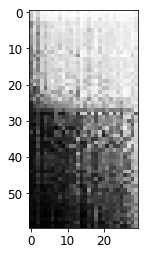

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [16]:
# IDEA:
# The model outputs probabilities. Instead of just printing black and white it may be interested to
# indicate the uncertainty of the model in grey teints
# p-verb = p-plural + p-singular, colorcode = p-plural/p-verb
# TIP: (p-plural, p-singular) = evaluate(lm, dictionary, sentence, check_words)

def gen_plurality_prob_matrix(NN, NNS, VBP, VBZ):
    assert(len(VBP) == len(VBZ))

    nouns = NN + NNS
    noun_count = len(nouns)
    verb_count = len(VBP)
    result = []
    for index_noun in range(noun_count):
        row = []
        for index_verb in range(verb_count):
            correct = VBZ[index_verb] if index_noun < len(NN) else VBP[index_verb]
            sentence = (f"the {nouns[index_noun]}", [VBP[index_verb], VBZ[index_verb]], correct)
            predictions = evaluate(lm, dictionary, sentence[0], sentence[1])
            p_plural = predictions[0][VBP[index_verb]]
            p_singular = predictions[1][VBZ[index_verb]]
            plurality_sureness = p_plural/(p_plural + p_singular)
            row.append(plurality_sureness)
        result.append(row)
    return result

n = 30
plurality_prob_matrix = np.array(gen_plurality_prob_matrix(NN[0:n], NNS[0:n], VBP[0:n], VBZ[0:n]))

plurality_prob_matrix = plurality_prob_matrix[np.argsort(-plurality_prob_matrix.sum(axis=1))]
plurality_prob_matrix = plurality_prob_matrix[:, np.argsort(plurality_prob_matrix.sum(axis=0))]

plt.imshow(plurality_prob_matrix, cmap=cm.gray)
plt.show(plurality_prob_matrix)

In [21]:
# Todo sort columns and rows and make sense of it (by looking at frequencies)

# matrix indicating 'singular' prediction (1=singular, 0 = plural)
noun_verb_matrix_singular_prediction = noun_verb_matrix_ratio.copy()
# f = np.vectorize(lambda x: 0 if x == 1 else 1)
# noun_verb_matrix_singular_prediction[n:] = f(noun_verb_matrix_ratio[n:])
# noun_verb_matrix_singular_prediction # NOUN x VERB, 1 = singular prediction, 0 = plural prediction

# sort columns (verbs) by their preference for singular prediction
noun_verb_matrix_singular_prediction_sorted_idx_col = np.argsort(-noun_verb_matrix_singular_prediction.sum(axis=0))
noun_verb_matrix_singular_prediction_sorted_col = noun_verb_matrix_singular_prediction[:, noun_verb_matrix_singular_prediction_sorted_idx_col]

# split in NN and NNS
matrix_NN = noun_verb_matrix_singular_prediction_sorted_col[:n]
matrix_NNS = noun_verb_matrix_singular_prediction_sorted_col[n:]

# sort rows by their preference for singular prediction
matrix_NN_sorted_idx_row = np.argsort(matrix_NN.sum(axis=1))
matrix_NN_sorted_row = matrix_NN[matrix_NN_sorted_idx_row,:]
matrix_NNS_sorted_idx_row = np.argsort(matrix_NNS.sum(axis=1))
matrix_NNS_sorted_row = matrix_NNS[matrix_NNS_sorted_idx_row,:]

#concatenate matrices
matrix = np.concatenate((matrix_NN_sorted_row, matrix_NNS_sorted_row),axis=0)

# NOUN x VERB, first half of the rows are singular nouns (NN) second half are plural nouns (NNS)
# 1 = singular prediction, 0 = plural prediction
# columns are sorted as follows: 
#   verb with preference for singular (VBZ) ... verb with preference for plural (VBP)
# rows are sorted as follows: 
#   singular noun (NN) correctly predicted singular most of the time
#   ...
#   singular noun (NN) incorrectly predicted plural often
#   plural noun (NNS) incorrectly predicted singular often
#   ...
#   plural noun (NNS) correctly predicted plural most of the time




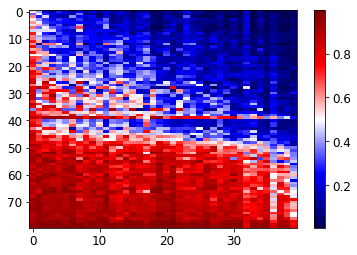

In [22]:
plt.imshow(matrix, cmap=cm.seismic,aspect='auto')
plt.colorbar()
plt.show()
plt.imsave('matrix_plot_ratio.png',matrix, cmap=cm.seismic)

